# NLP methods applied to FTS transfer error messages

**Objective:** 

 - extract FTS transfer error data
 - explore the data
 - apply NLP ethods to error messages
 - possibly account for other features as well (e.g. source/destination sites, tansferprotocol, ...)

In [1]:
%%time

# start Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").appName("NLP_on_FTS").getOrCreate()
#spark = SparkSession.builder.master("local[*]").appName("fts_data").getOrCreate()
spark

CPU times: user 43.5 ms, sys: 30 ms, total: 73.5 ms
Wall time: 9.05 s


## Import data

**Note:** the period 7/10 - 10/10 is considered since there should be an issue with an FTS instance and we want our approach to be able to spot it.

In [2]:
test_data = spark.read.csv("test_data.csv", header=True)
# test_data.cache()
# test_data.show()

In [3]:
test_data.columns

['vo',
 'src_url',
 'dst_url',
 'src_hostname',
 'dst_hostname',
 't_channel',
 'timestamp_tr_st',
 'timestamp_tr_comp',
 't_error_code',
 'tr_error_scope',
 't_failure_phase',
 'tr_error_category',
 't_final_transfer_state',
 't__error_message',
 'hlg']

### Variables' description

<div class="alert alert-block alert-danger">
<b>Reminder:</b> Check variable relevance to error detection with domain experts and then i) shorten the list (only relevant features with explanations), ii) add reference to documentation, iii) add legend with message/auxiliary variable colors. 
</div>


The following list contains a description of the variables' content:

**Generic information:**
  - **<font color='green'>"vo"</font>:** "Virtual Organization",
  - **<font color='green'>"src_hostname"</font>:** "Source hostname",
  - **<font color='green'>"dst_hostname"</font>:** "Destination hostname",
  - **<font color='green'>"t_channel"</font>:** "source_protocol://source_host__dest_protocol://dest_host",

**Time information:**
  - **<font color='green'>"timestamp_tr_comp"</font>:** 0, // Timestamp of the whole process completion, in milliseconds


**Error informations:**
  - **<font color='red'>"t_error_code"</font>:** 0, // Error code: an errno value (i.e. ENOENT)
  
  > corresponds to the errno value returned by the url-copy process (i.e. ENOENT)
  
  - **<font color='red'>"tr_error_scope"</font>:** "Error scope, empty if ok",
  
  > 3 possible values, SOURCE, TRANSFER and DESTINATION depending on where the error happens. SOURCE for instance is set if the source file is not there or the source checksum query fails.
  
  - **<font color='red'>"t_failure_phase"</font>:** "Error phase, empty of ok",
  
  > 3 possible values TRANSFER_PREPARATION, TRANSFER, TRANSFER_FINALIZATION ( more or less they map to the values of tr_error_scope)
  
  - **<font color='red'>"tr_error_category"</font>:** "Error category, empty if ok",
  
  > this is the string representation of the t_error_code as returned by the strerror_r function (https://linux.die.net/man/3/strerror_r), possible values are:
COMMUNICATION_ERROR_ON_SEND, FILE_EXIST, PERMISSION_DENIED, etc

  - **<font color='red'>"t_final_transfer_state"</font>:** "Ok|Error|Abort",

  > != "Ok" for errors

  - **<font color='red'>"t__error_message"</font>:** "Error message, empty if ok",
  
  > string error from the storage


In [4]:
test_data.count()

1736678

#### Correct messages for url parsing 

In [3]:
def deal_with_urls(url):
    from urllib.parse import urlparse
    parsed = urlparse(url)
    if parsed.scheme:
        if parsed.path and parsed.netloc:
            res = ' '.join([parsed.scheme + "://" + parsed.netloc, parsed.path])
        elif parsed.path:
            res = parsed.scheme + ":" + parsed.path
        else:
            res = parsed.scheme + ":"
    elif parsed.params:
        res = ' '.join([parsed.path.strip("."), parsed.params])
    else:
        res = parsed.path
    return(res)

def split_urls(string):
    '''Take a string and split url into netloc + path'''
    from urllib.parse import urlparse
    tks = [deal_with_urls(x) for x in string.split()]
    return(' '.join(tks))


def split_concatenation_errors(string, split_char="-"):
    """"""   
    if split_char in string:
        try:
            int(string.split(split_char)[0])
            number = string.split(split_char)[0]
            literal = string.replace(number+split_char, "")
            return([number, literal])
        except ValueError:
            return(string)
    else:
        return(string)

def clean_tokens(entry, custom_split=False):
    """Remove punctuation at the end of tokens and disard empty tokens"""
    def flatten(ul):
        """"""
        fl = []
        for i in ul:
            if type(i) is list:
                fl += flatten(i)
            else:
                fl += [i]
        return fl
    
    if custom_split:
        tks_cleaned = [split_concatenation_errors(tks.strip(":;,.- ")) 
                       for tks in entry if tks!=""]
        tks_cleaned = flatten(tks_cleaned)
    else:
        tks_cleaned = [tks.strip(":;,.- ") for tks in entry if tks!=""]
    return(tks_cleaned)

In [4]:
import pyspark.sql.functions as F

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType

# transform in user defined function
split_urls_udf = udf(split_urls, StringType())

# split urls appropriately
test_data = test_data.select("t__error_message").withColumn("corrected_message", split_urls_udf("t__error_message"))

# add row id
test_data = test_data.withColumn("msg_id", F.monotonically_increasing_id()).select("msg_id", "t__error_message", "corrected_message")

##### Tokenization 

In [5]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# split text into tokens
tokenizer = Tokenizer(inputCol="corrected_message", outputCol="tokens")
vector_data = tokenizer.transform(test_data)

# transform in user defined function
clean_tokens_udf = udf(lambda entry: clean_tokens(entry, custom_split=True), ArrayType(StringType()))

# clean tokens
vector_data = vector_data.withColumn("tokens_cleaned", clean_tokens_udf("tokens"))

# remove stop (common, non-relevant) words
stop_remove = StopWordsRemover(inputCol="tokens_cleaned", outputCol="stop_token")
stop_remove1 = StopWordsRemover(inputCol="stop_token", outputCol="stop_token_1", stopWords=["", ":", "-"])

#### TF-IDF 

In [6]:
from pyspark.ml.feature import CountVectorizer, IDF

# count frequency of each token in each text (bag of words model)
count_vec = CountVectorizer(inputCol="stop_token_1", outputCol="count_vec")

# compute  tf-idf
idf = IDF(inputCol="count_vec", outputCol="tf_idf")

In [7]:
from pyspark.ml import Pipeline

data_prep_pipeline = Pipeline(stages = [stop_remove, stop_remove1, count_vec, idf])

pipeline_executor = data_prep_pipeline.fit(vector_data)

In [8]:
%%time

vector_data = pipeline_executor.transform(vector_data)

CPU times: user 54.8 ms, sys: 12.4 ms, total: 67.2 ms
Wall time: 363 ms


##### Inspect results 

In [12]:
for row in vector_data.limit(100).select("t__error_message", "corrected_message","stop_token_1").collect():
    print("\n\nMessage: {}\n".format(row[0]))
    print("corrected: {}\n".format(row[1]))
    print("tokens: {}".format(row[2]))



Message: SOURCE CHECKSUM globus_ftp_client: the server responded with an error 500 error: commands denied

corrected: SOURCE CHECKSUM globus_ftp_client: the server responded with an error 500 error: commands denied

tokens: ['source', 'checksum', 'globus_ftp_client', 'server', 'responded', 'error', '500', 'error', 'commands', 'denied']


Message: TRANSFER  globus_ftp_client: the server responded with an error 500 500-System error in mkdir: Transport endpoint is not connected  500-A system call failed: Transport endpoint is not connected  500 End.

corrected: TRANSFER globus_ftp_client: the server responded with an error 500 500-System error in mkdir: Transport endpoint is not connected 500-A system call failed: Transport endpoint is not connected 500 End.

tokens: ['transfer', 'globus_ftp_client', 'server', 'responded', 'error', '500', '500', 'system', 'error', 'mkdir', 'transport', 'endpoint', 'connected', '500', 'system', 'call', 'failed', 'transport', 'endpoint', 'connected', '500

In [13]:
for row in vector_data.limit(10).select("t__error_message","tf_idf").collect():
    print("\n\nMessage: {}\n".format(row[0]))
    print("tf_idf: {}".format(row[1]))



Message: SOURCE CHECKSUM globus_ftp_client: the server responded with an error 500 error: commands denied

tf_idf: (160758,[0,9,10,11,20,23,61,66,72],[0.5915061562721056,1.1048574245539746,1.104859162812257,1.104859162812257,2.347392822859752,1.487919788957676,2.9414038800443216,3.0944807708469626,3.247943148709106])


Message: TRANSFER  globus_ftp_client: the server responded with an error 500 500-System error in mkdir: Transport endpoint is not connected  500-A system call failed: Transport endpoint is not connected  500 End.

tf_idf: (160758,[0,2,5,9,10,11,20,22,44,45,59,290,337,387],[0.5915061562721056,0.5152522661341862,0.9872090162894467,1.1048574245539746,1.104859162812257,1.104859162812257,9.389571291439008,4.125063023846989,2.127339710900361,2.146814651377939,5.583226264085784,13.971966664513927,14.889682670575565,7.5355316611978145])


Message: TRANSFER  globus_xio: Unable to connect to starsky.nikhef.nl:2811 globus_xio: System error in connect: Connection timed out globus_

<div class="alert alert-block alert-info">
    <b>Note:</b> the column <i>tf_idf</i> is a tuple <b>(#tokens_dictionary, array_token_index, array_token_tf_idf)</b>
</div>

Let now try to visualise how tokens are weighted within some messages:

In [14]:
from pyspark.ml.feature import CountVectorizerModel

stages = pipeline_executor.stages
vectorizers = [s for s in stages if isinstance(s, CountVectorizerModel)]

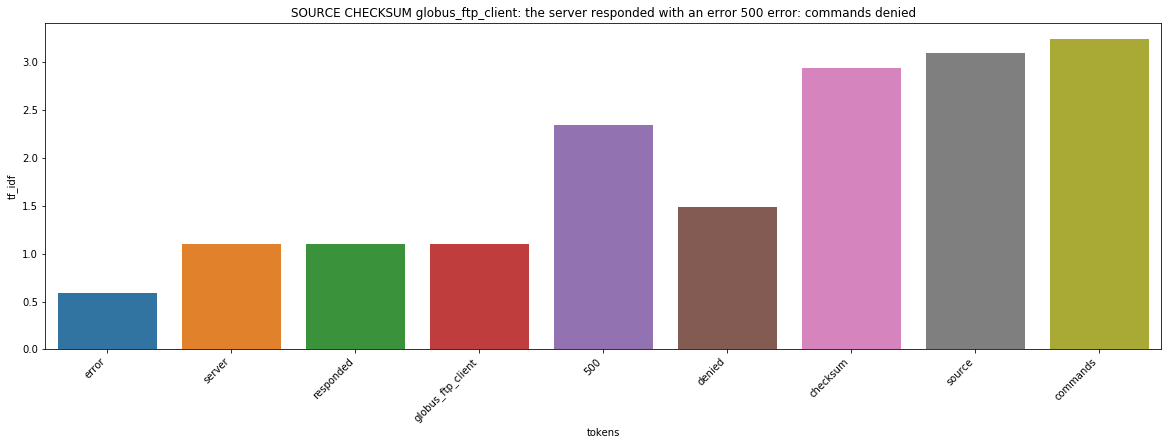

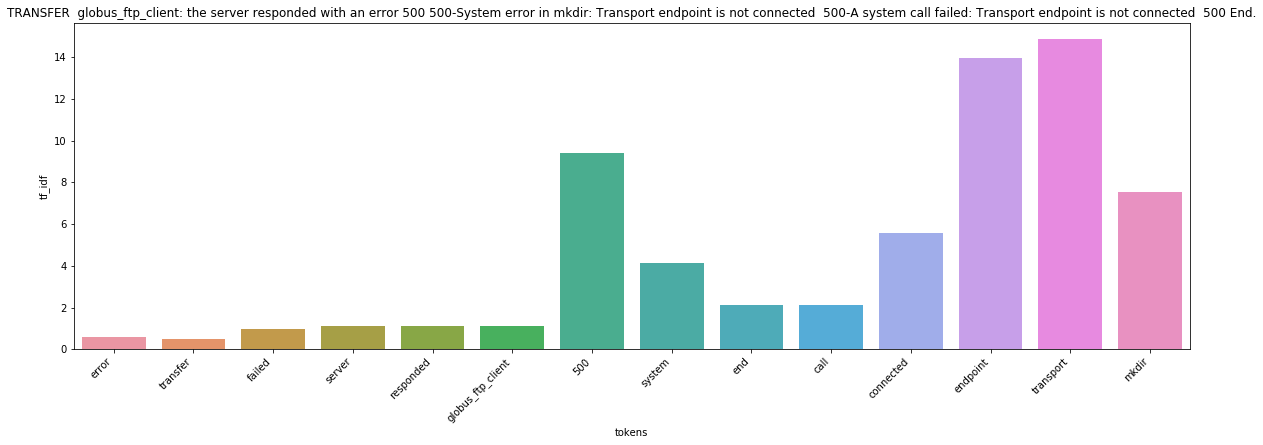

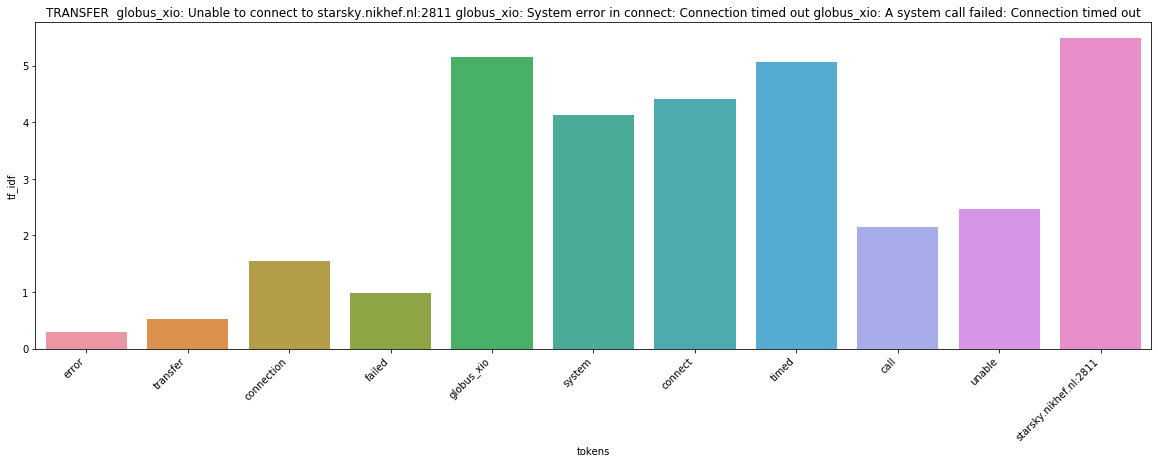

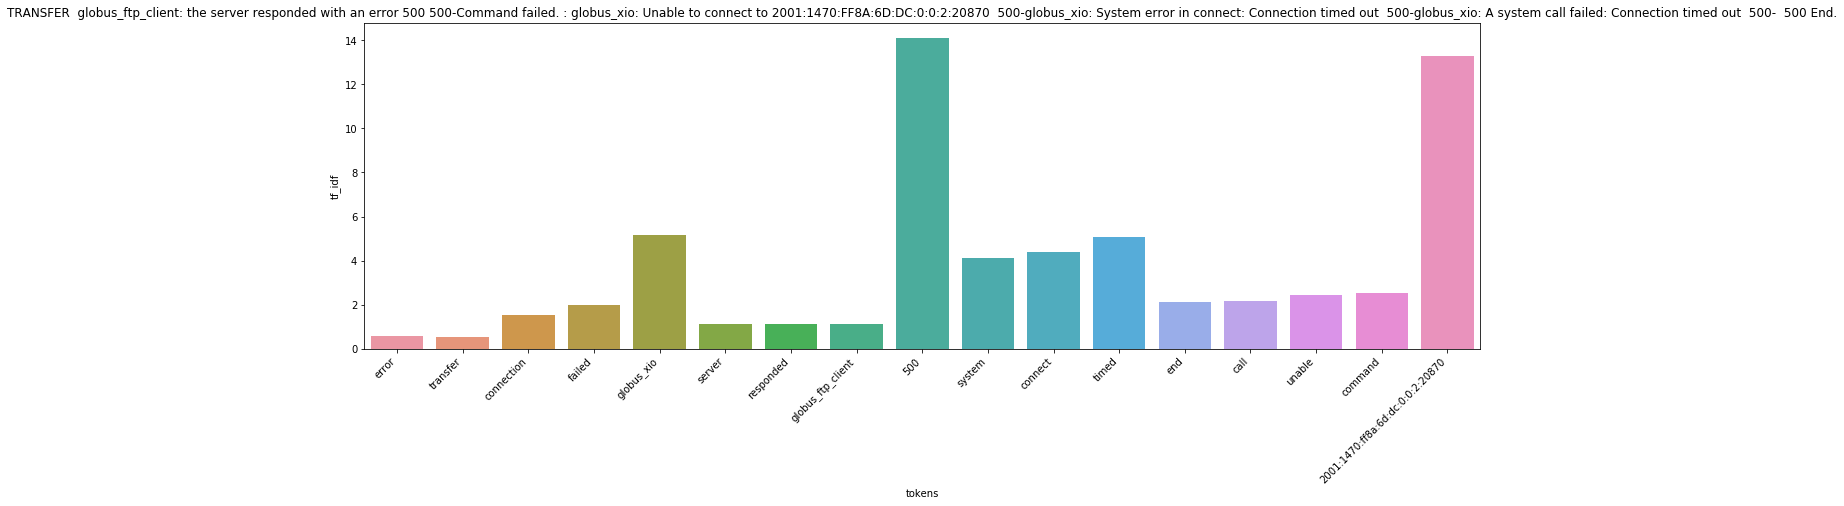

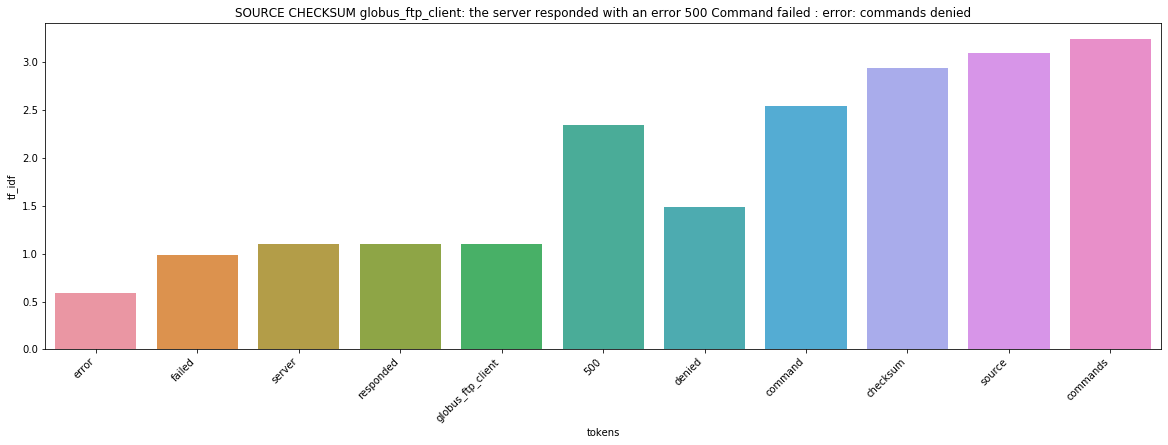

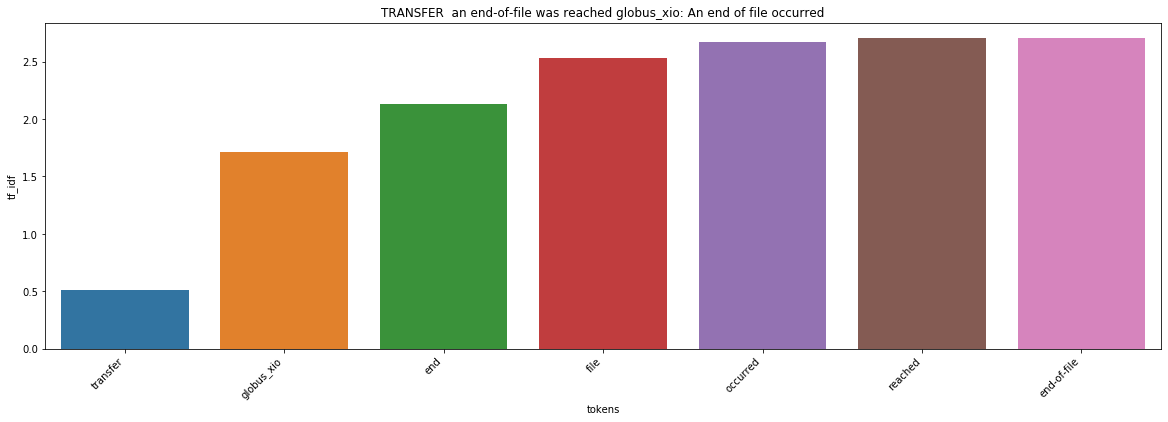

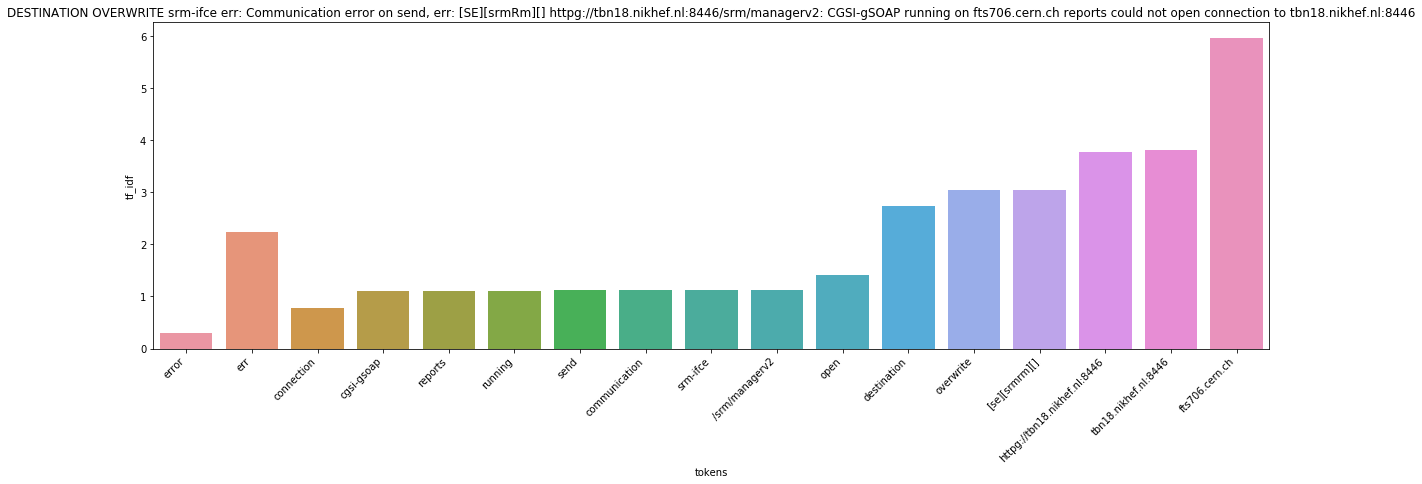

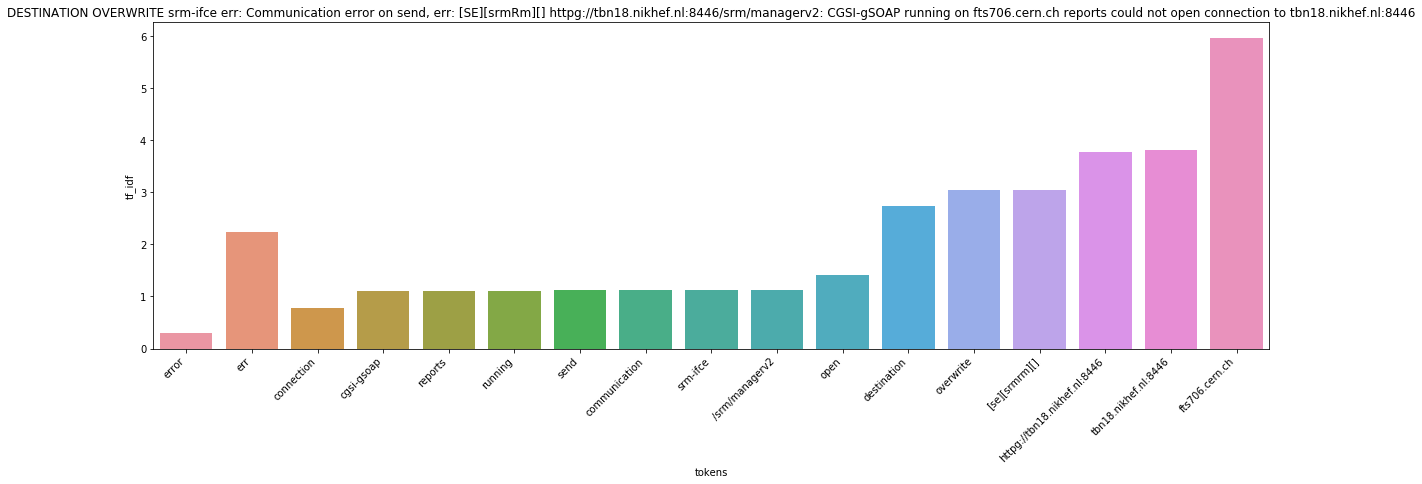

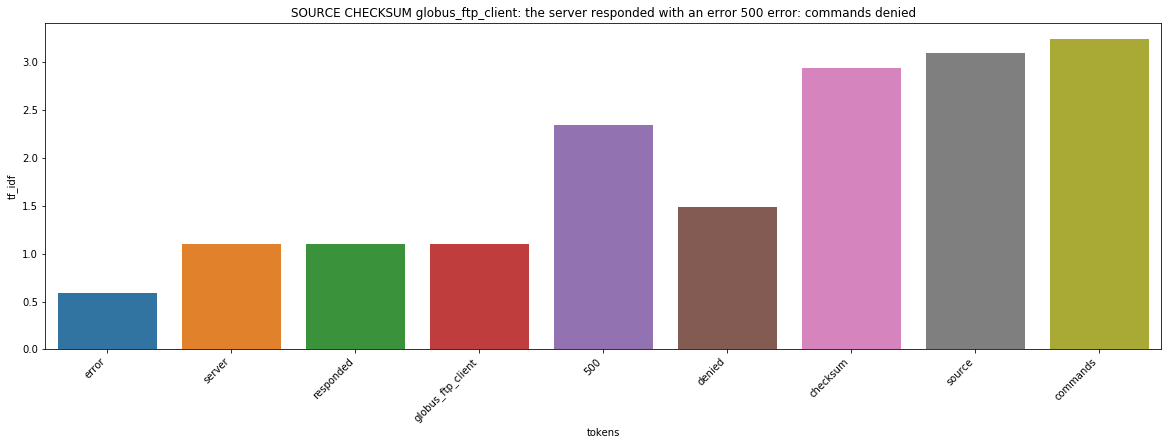

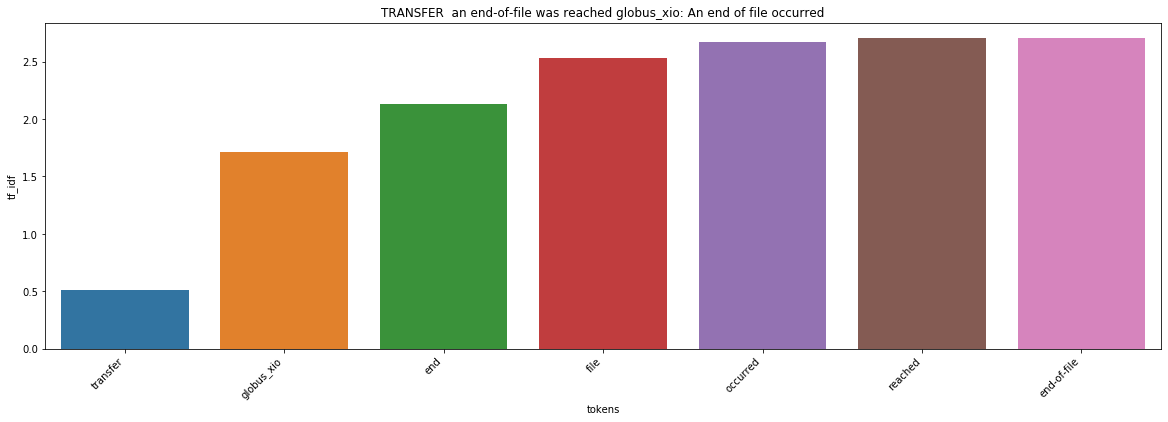

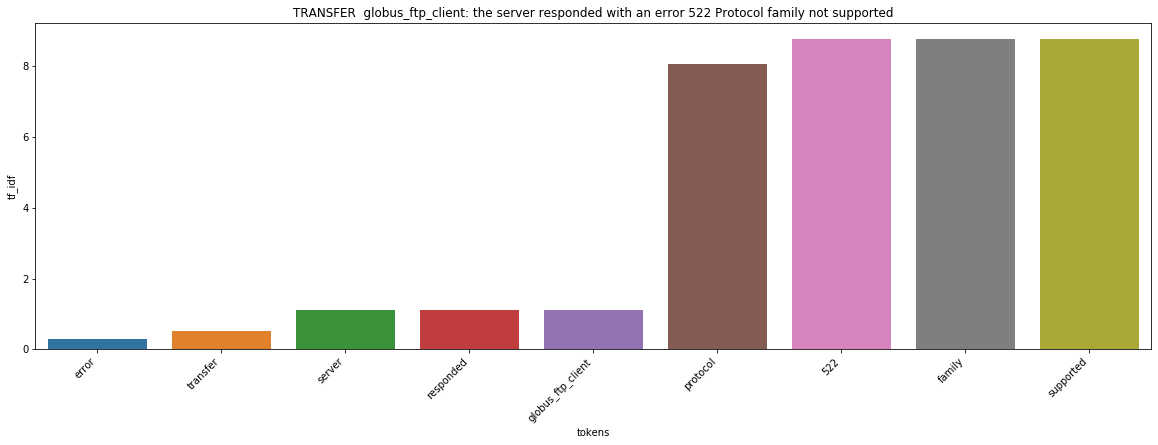

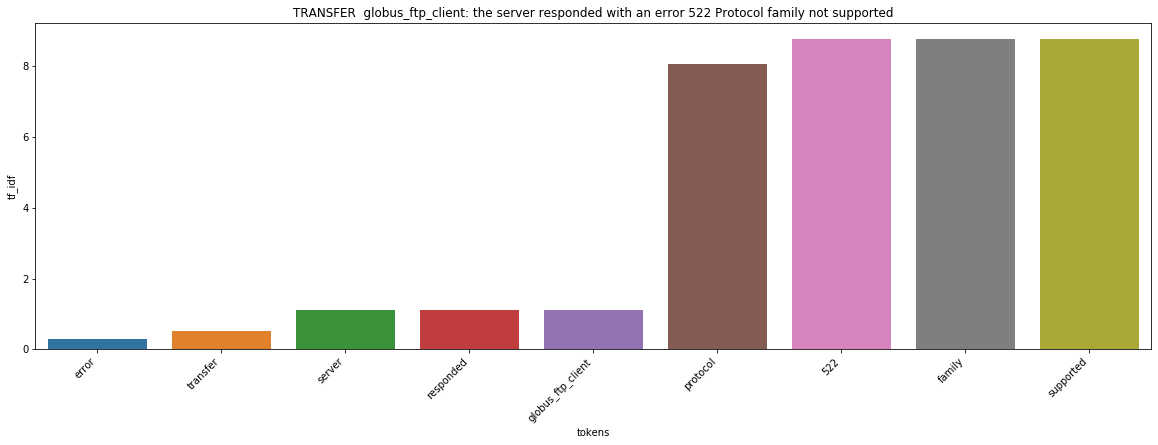

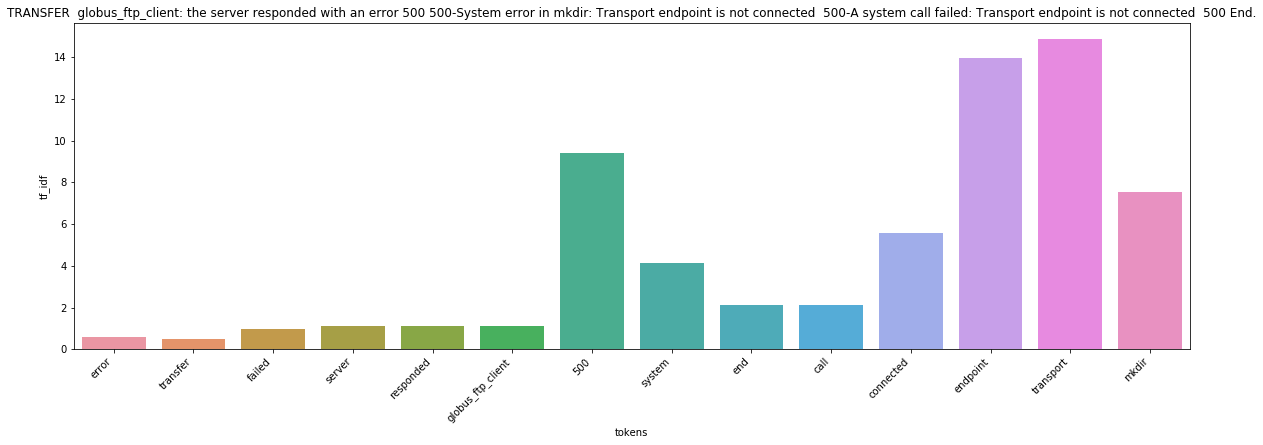

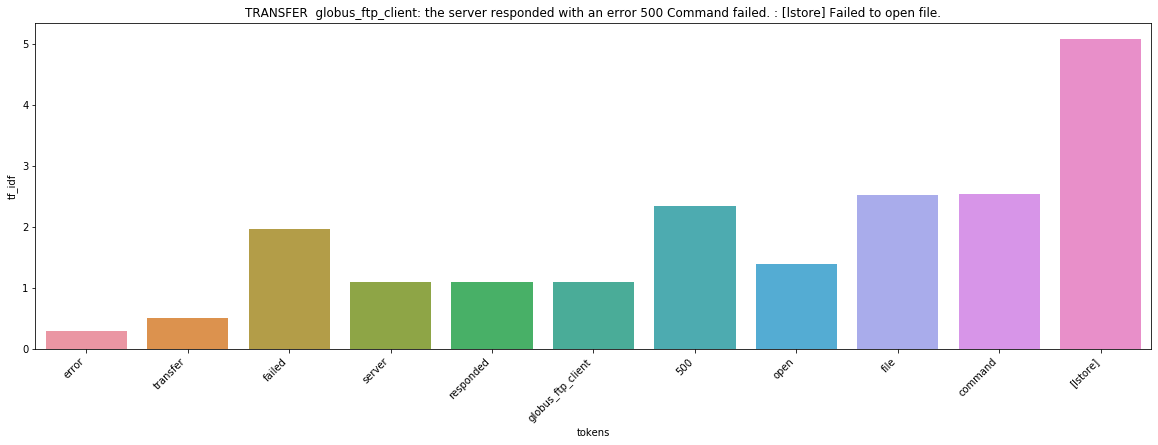

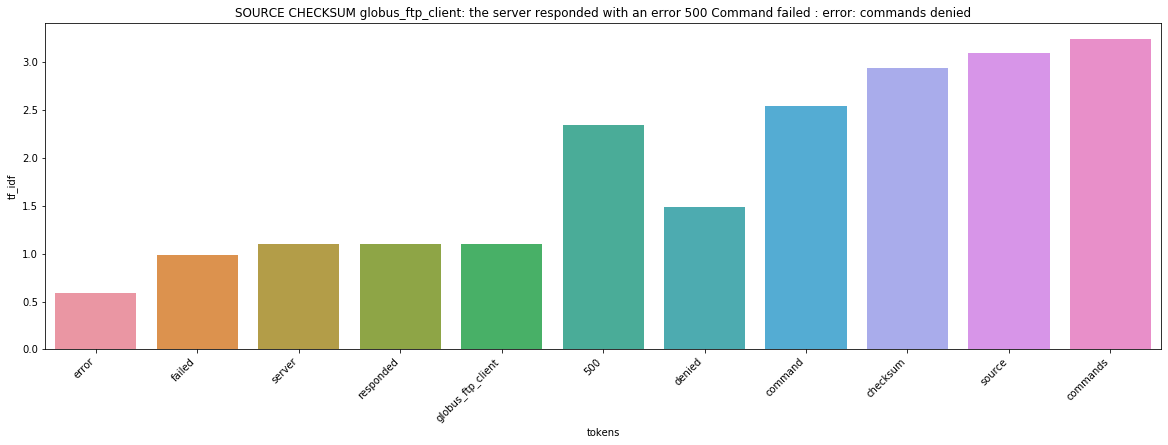

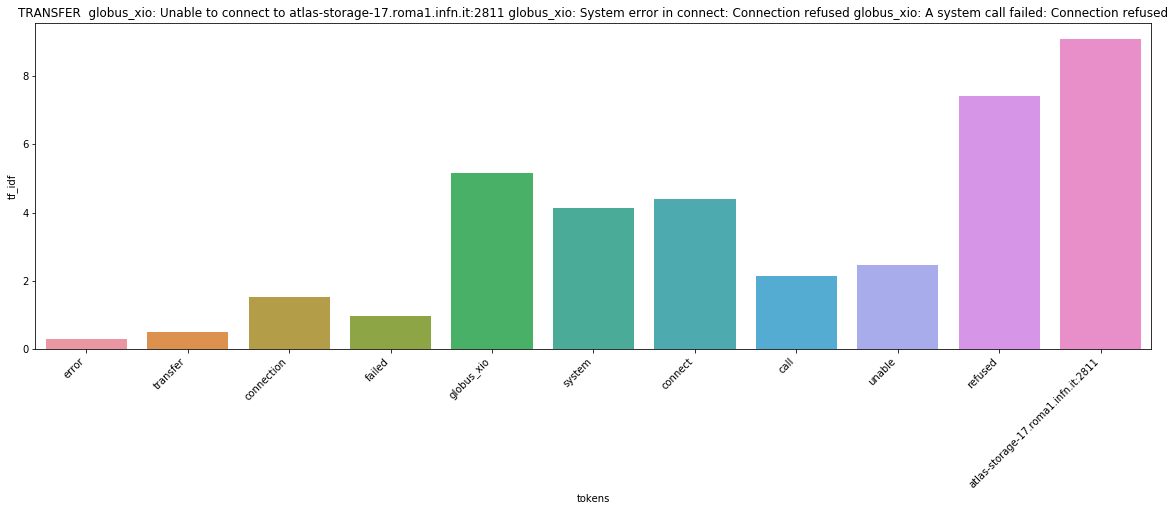

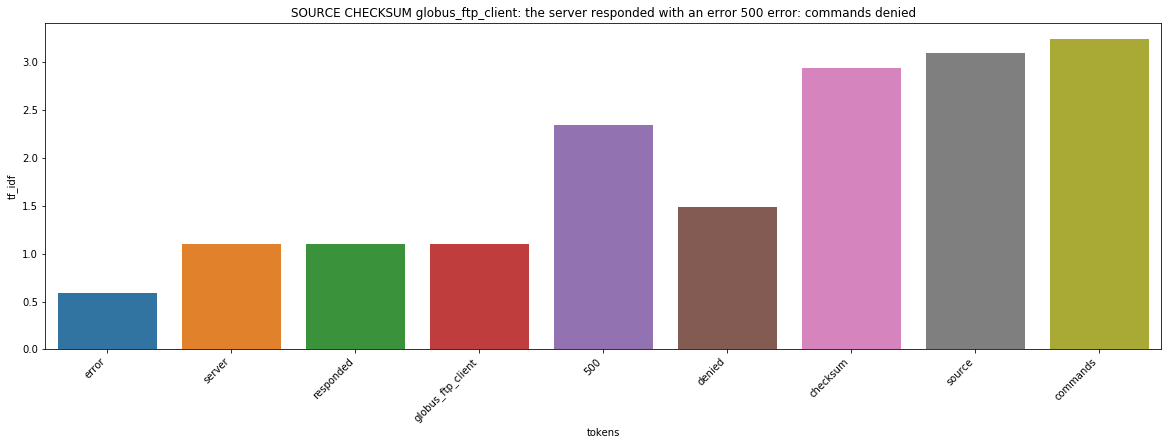

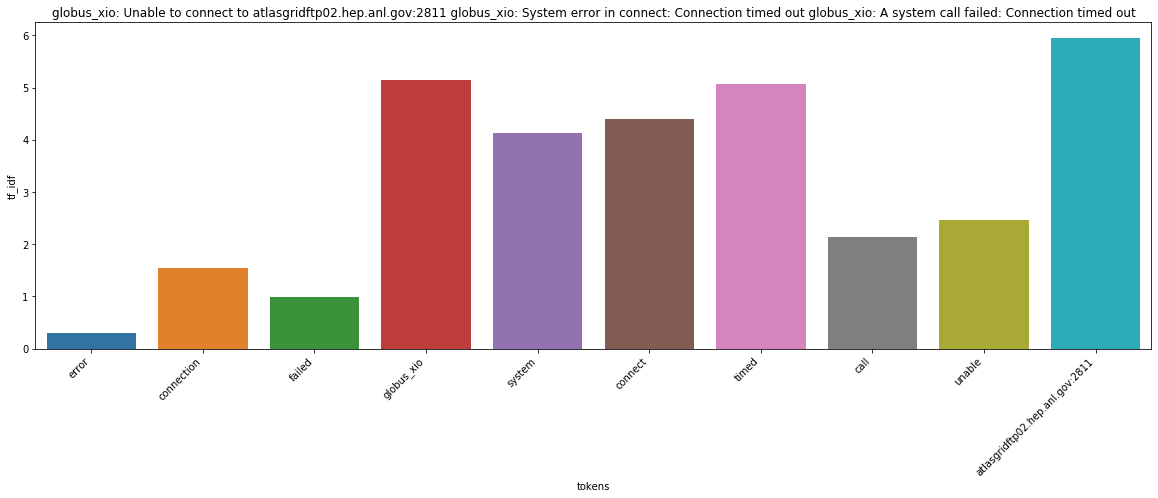

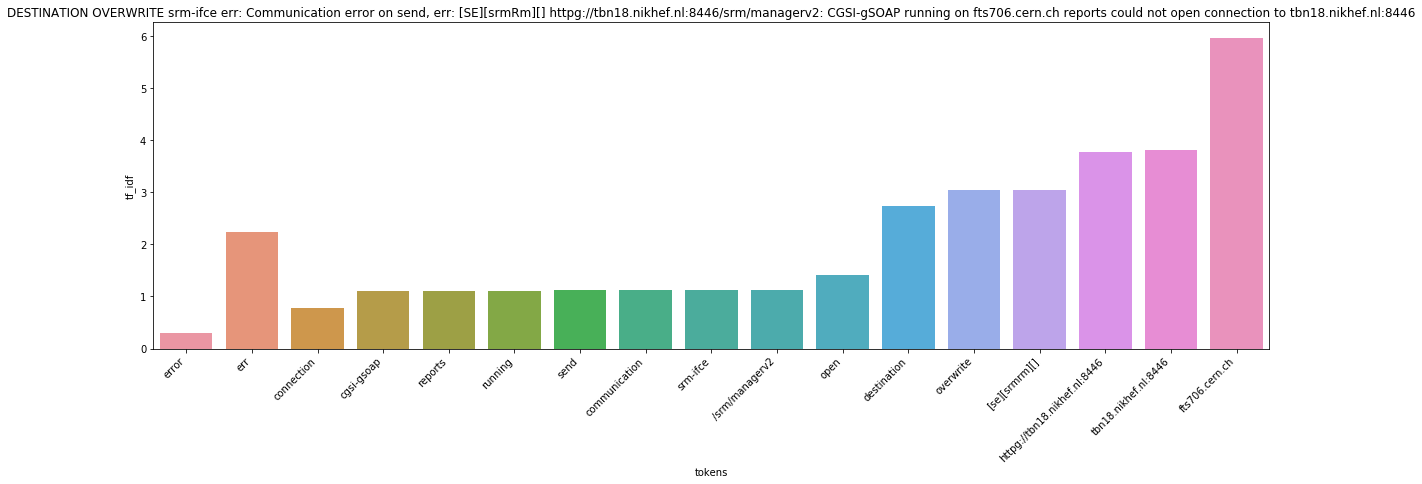

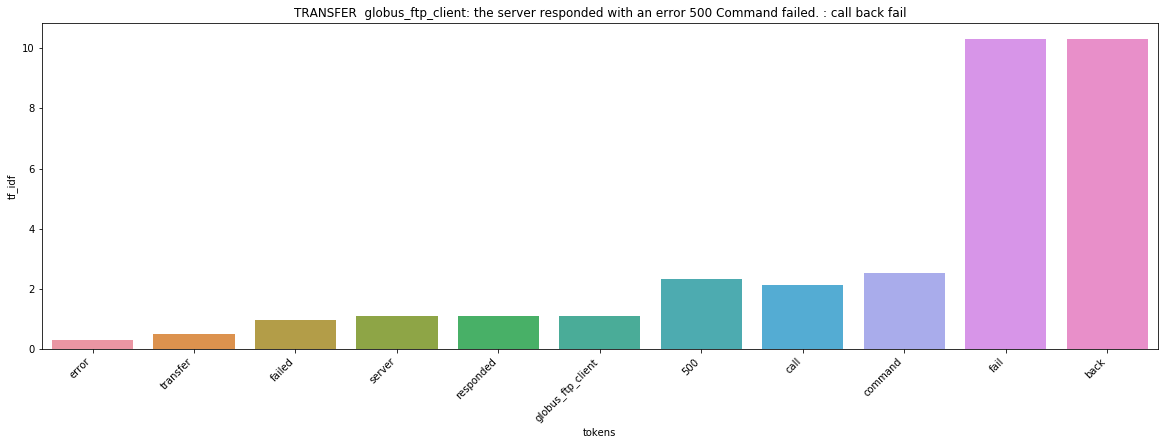

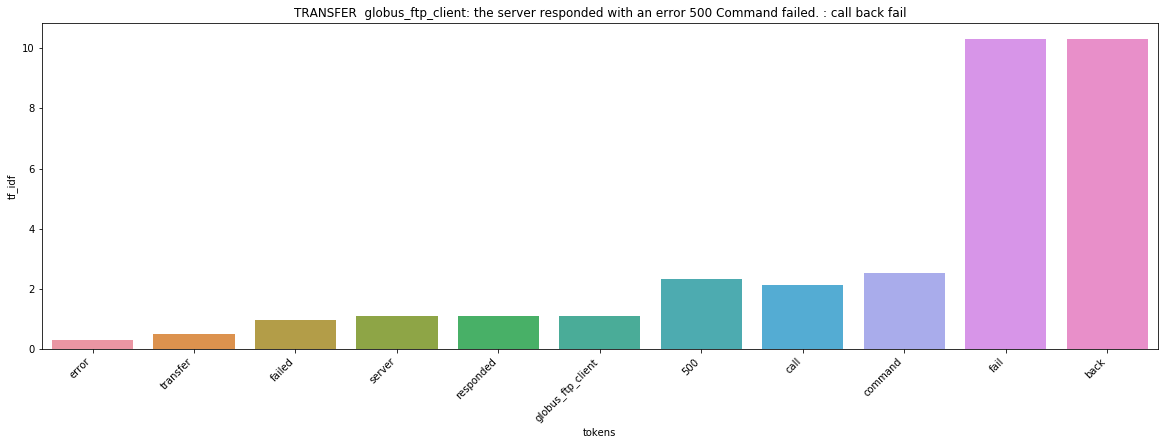

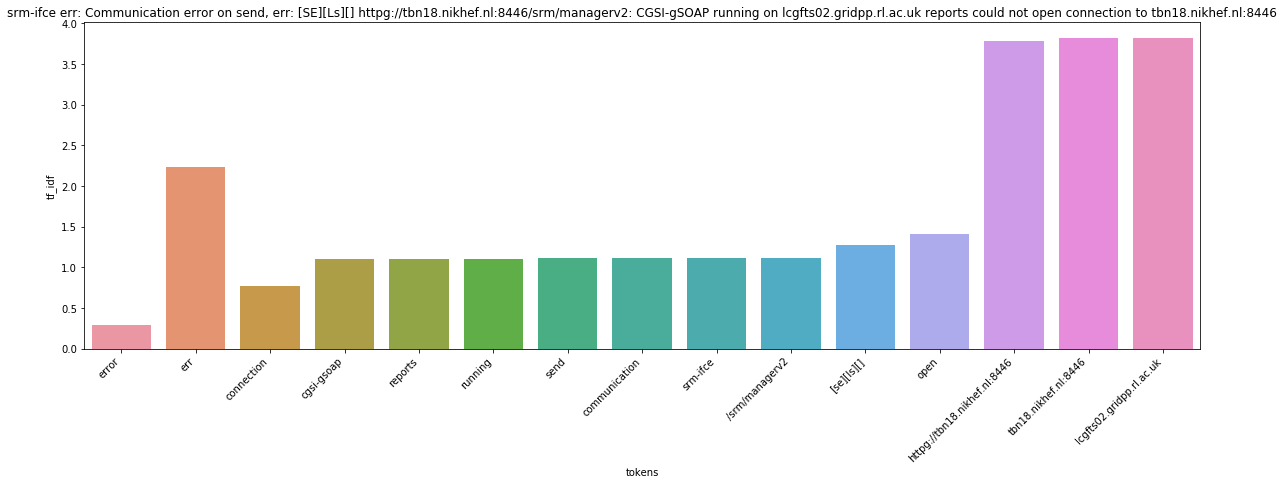

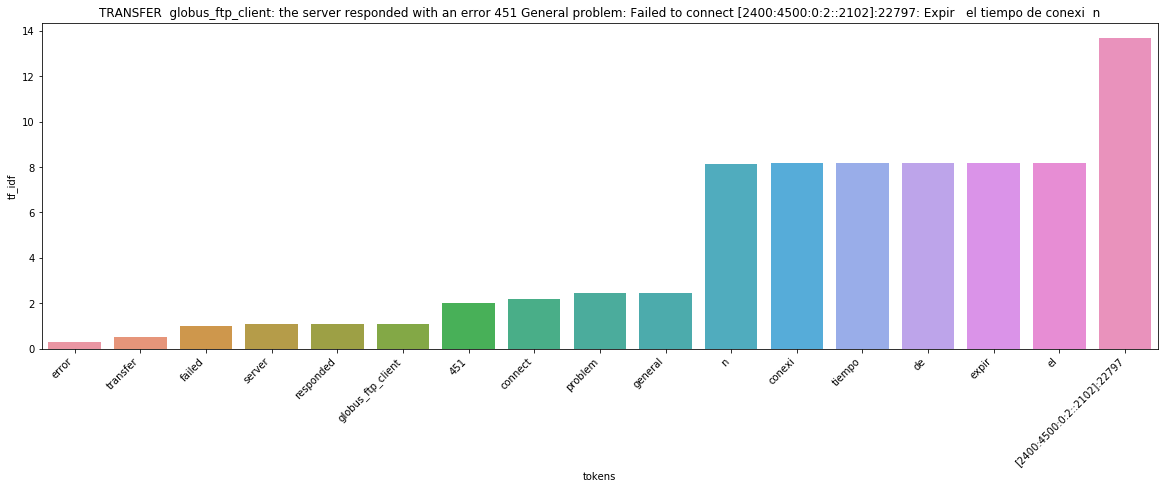

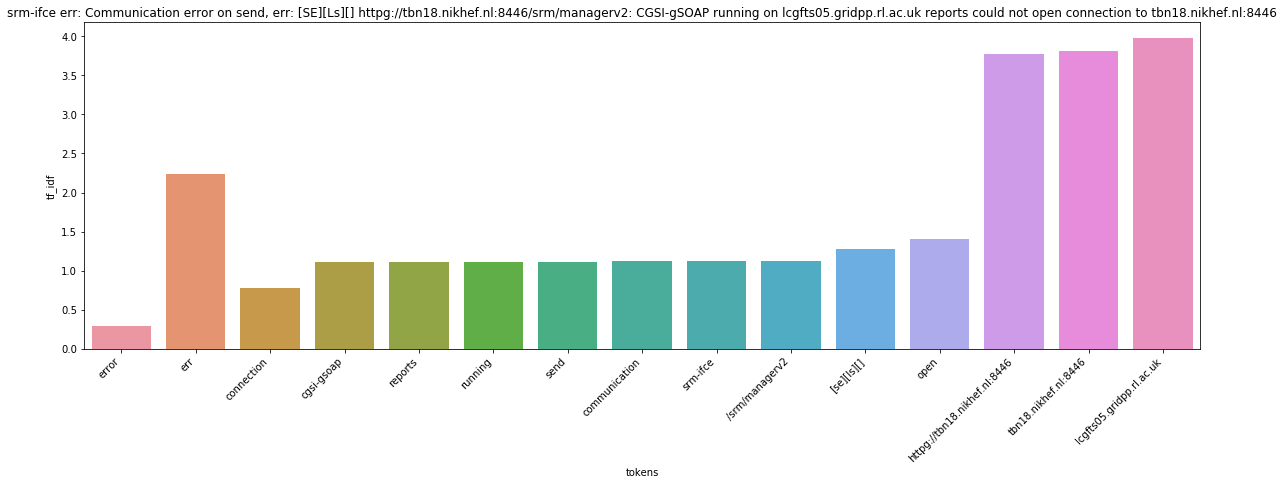

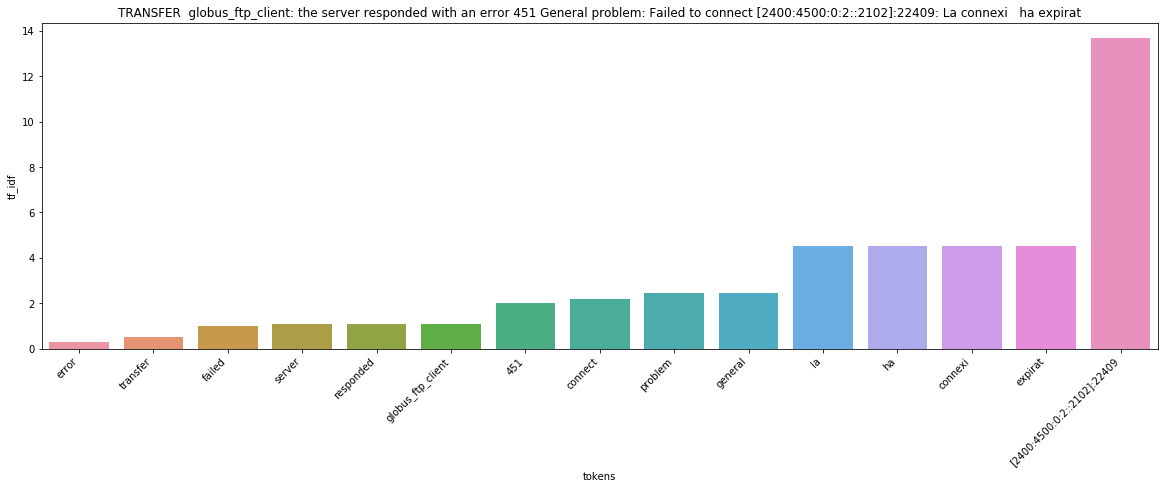

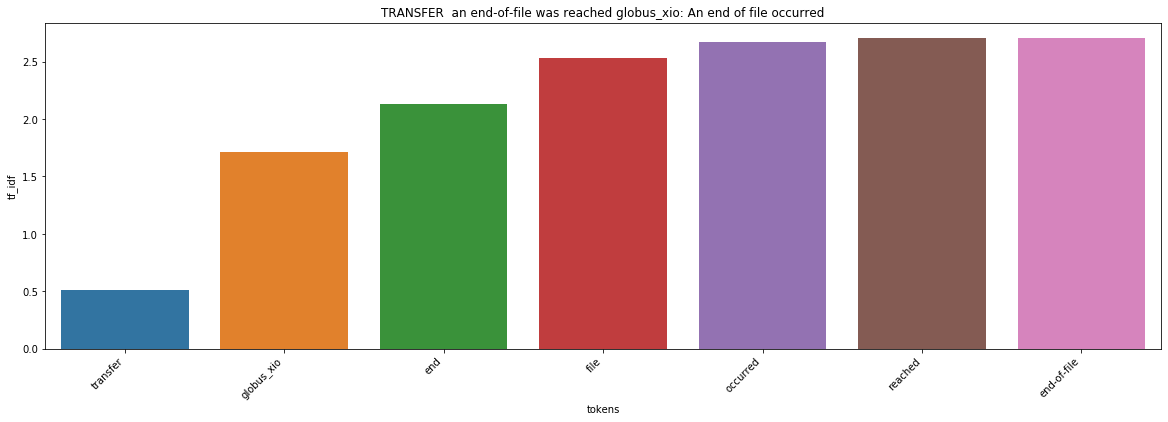

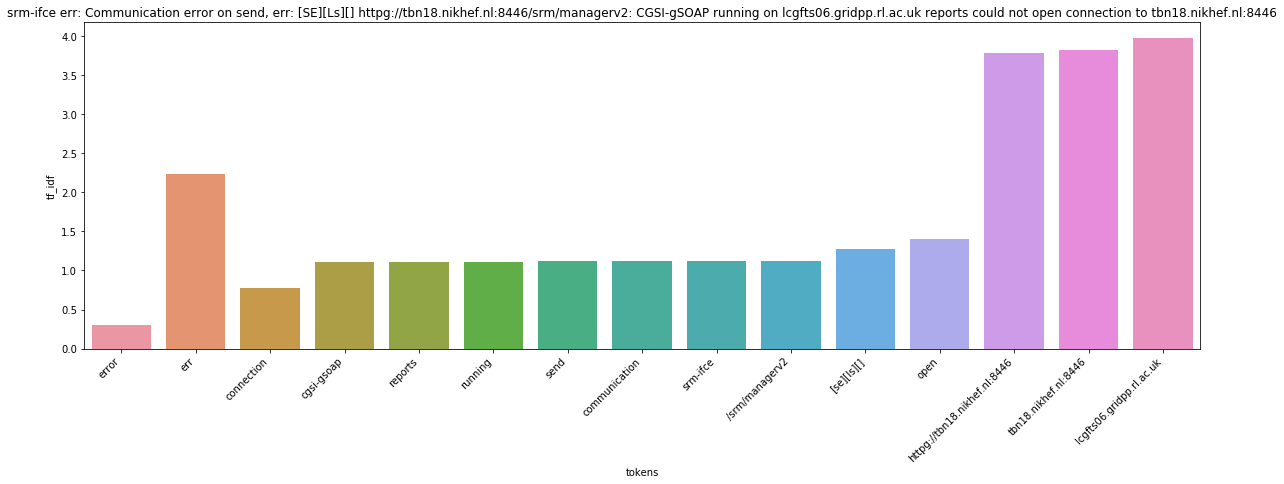

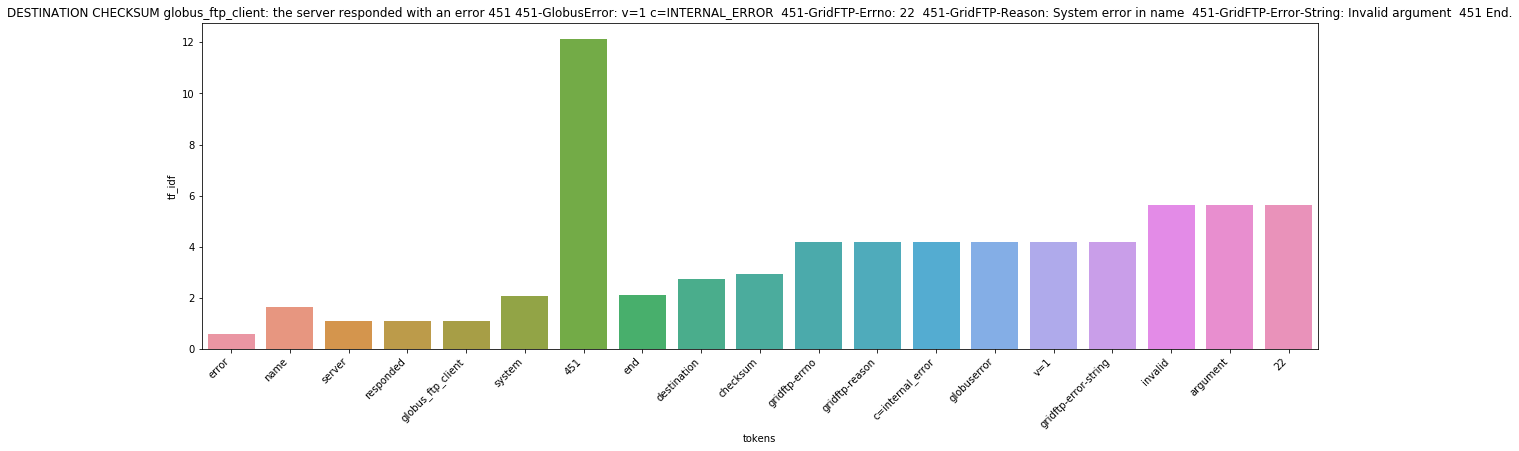

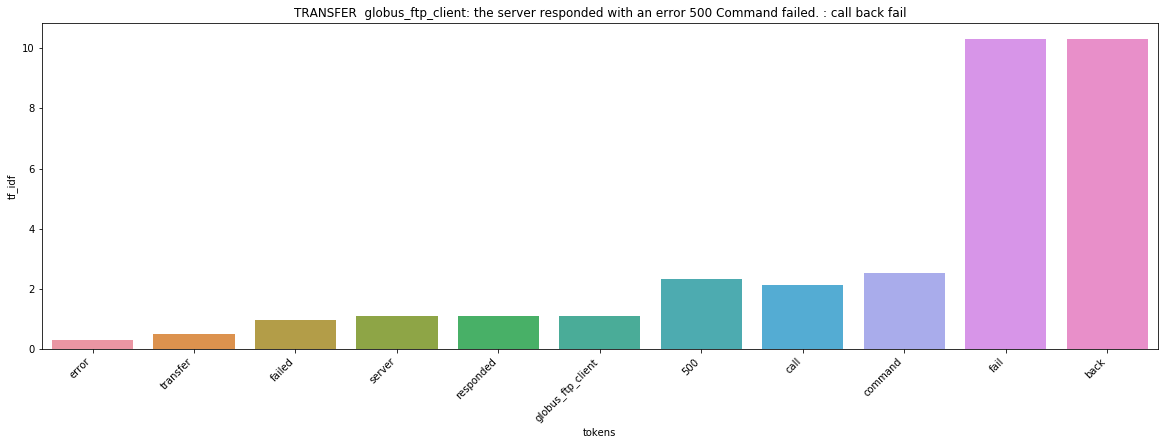

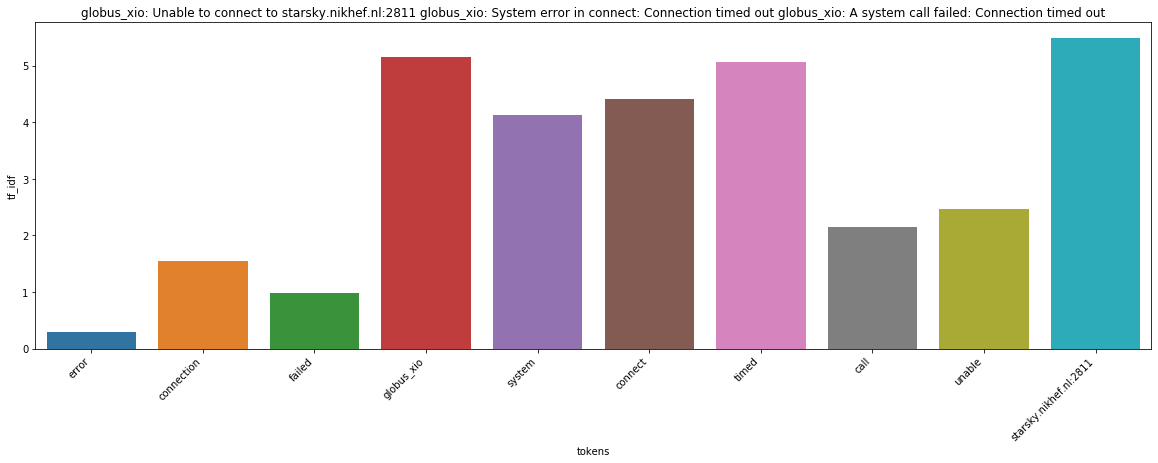

In [16]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt



for i, row in enumerate(vector_data.limit(30).select("stop_token_1","tf_idf", "t__error_message").collect()):
    
    # extract data
    y = row[1]
    x = [vectorizers[0].vocabulary[x] for x in y.indices]#row[0]#.split()
    data = pd.DataFrame({"tokens": x,"tf_idf": y.values})

    fig, ax = plt.subplots(figsize=(20,6))
    plt.title(row[2])
    g = sns.barplot(ax=ax, x="tokens", y="tf_idf", data=data)
    _ = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.show()

```list(set(vocab_nodash) - set(vocab_dash))```

['451-gridftp-reason',
 '500-internal',
 '500-globus_common',
 '451-gridftp-errno',
 '500-an',
 '500-globus_xio',
 '451-globuserror',
 '500-gridftp-reason',
 '500-globus_xio_system_select.c:globus_l_xio_system_handle_write:1108',
 '500-a',
 '500-system',
 '500-globuserror',
 '500-unable',
 '500-handle',
 '451-gridftp-error-stri',
 '500-command',
 '451-gridftp-error-string',
 '500-gridftp-error-string',
 '500-gridftp-errno']
 
 ```list(set(vocab_dash) - set(vocab_nodash))```

['an',
 'globus_xio_system_select.c:globus_l_xio_system_handle_write:1108',
 'gridftp-errno',
 'a',
 'gridftp-error-string',
 'gridftp-error-stri',
 'gridftp-reason']
 
 ```len(vocab_dash), len(vocab_nodash)```
 
 (160764, 160776)

#### Word2Vec 

In [9]:
# subsample data
sub1 = vector_data.sample(withReplacement=False, fraction=0.3, seed=4)

In [18]:
from pyspark.ml.feature import Word2Vec

In [21]:
%%time

# intialise word2vec
word2vec = Word2Vec(vectorSize = 200, minCount = 1, inputCol = 'stop_token_1', outputCol = 'message_vector')

# for i in range(550000, 900000, 50000):
#     # fit the model
#     print(i)
#     train_data = vector_data.select("stop_token").limit(i)
#     model = word2vec.fit(train_data)

train_data = sub1.select("stop_token_1")#.limit(500000)
# train_data = vector_data.select("stop_token").limit(500000)
model = word2vec.fit(train_data)

CPU times: user 608 ms, sys: 146 ms, total: 754 ms
Wall time: 10min 29s


##### Save Model 

In [22]:
# model.save("word2vec_trial_500000") # first attempt
# model.save("word2vec_trial_500000_2") # second attempt
# model.save("word2vec_trial_random_sample") # ~513k rows
model.save("word2vec_trial_random_sample_cleaned-tks") # ~513k rows

<div class="alert alert-block alert-info">
    <b>Note:</b> I should probably scale the stop_words column before feeding it into word2vec model.
</div>

#####  Save results

In [10]:
# load back the word2vec model
from pyspark.ml.feature import Word2VecModel
w2vec_model = Word2VecModel.load('word2vec_trial_random_sample_cleaned-tks')

# apply it to the data to obtain the embedded representation
train_data = sub1.select("msg_id", "t__error_message", "stop_token_1")#.limit(500000)
train_data = w2vec_model.transform(train_data)

In [11]:
train_data.count(), len(train_data.columns)

(520955, 4)

In [12]:
train_data.columns

['msg_id', 't__error_message', 'stop_token_1', 'message_vector']